## Set-up

In [5]:
import tifffile
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from pathlib import Path
import gc
from matplotlib import colormaps as cm
from glob import glob

import sys
import os

module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

import utils
import track

2024-06-19 16:27:40.689842: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-19 16:27:40.735556: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-19 16:27:40.735587: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-19 16:27:40.736407: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-19 16:27:40.741777: I tensorflow/core/platform/cpu_feature_guar

### Hyper parameters

In [6]:
loadstar_weight_name = "loadstar_first"
magik_weight_name = "MAGIK_MP_MPN"

# Experiment parameters
dir_mode = True
input_path = r'/home/gideon/data/data_VE/test' # Change this to where you have the tiff file
output_path = r'/home/gideon/Documents/PhD/Projects/KAW/output' # Change this to where you want the output to be saved
pages_batch_size = 2
channel_width = 0.3 # Microns

# Loadstar parameters
alpha = 0.999
cutoff = 0.00000002

# MAGIK parameters
radius = 0.08 # Value between 0 and 1 where 1 is the full image hight
traj_min = 6
n_frames = 4

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

loadstar, magik = utils.load_models(loadstar_weight_name, magik_weight_name)

if dir_mode:
    image_paths = glob(input_path + '/*.tif')
else:
    image_paths = [input_path]

Num GPUs Available:  0


In [7]:
for path in image_paths:
    print(path)

/home/gideon/data/data_VE/test/Experiment-16031.tif
/home/gideon/data/data_VE/test/Experiment-22070.tif


#### Test loadstar parameters

1/1 [==============================] - 1s 679ms/step


[]

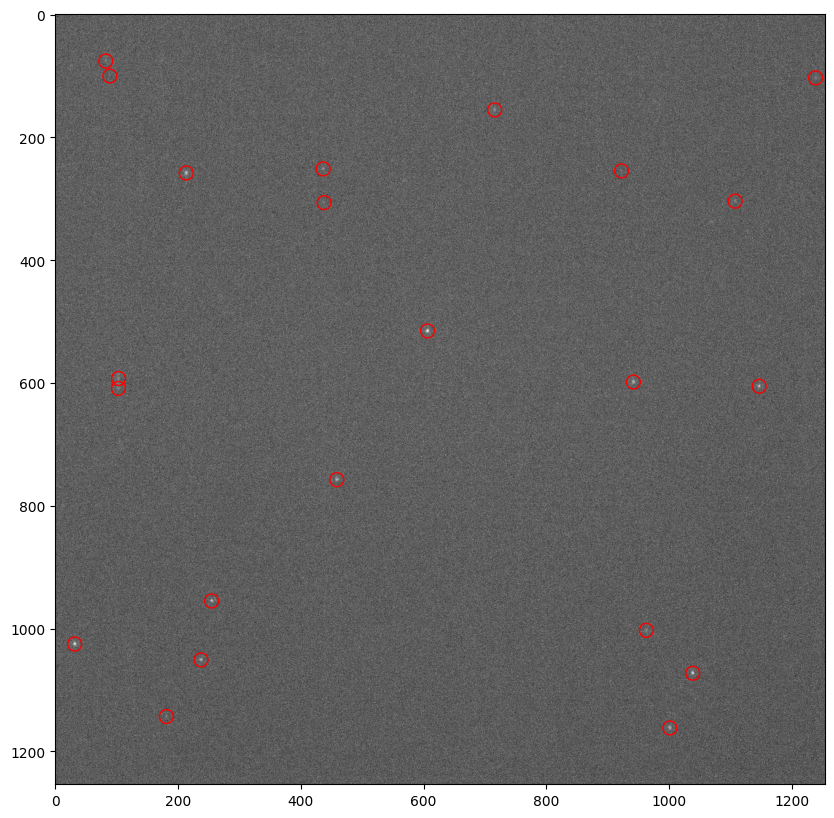

In [8]:
utils.test_loadstar(image_paths[0], loadstar, alpha, cutoff, 1)

### Extract metadata

In [9]:
tiffpage = tifffile.TiffFile(image_paths[1]).pages[0]
for tag in tiffpage.tags.values():
    print(tag.name, tag.value)    


NewSubfileType 0
ImageWidth 1254
ImageLength 1254
BitsPerSample 16
Compression 1
PhotometricInterpretation 1
ImageDescription ImageJ=1.54f
images=500
frames=500
unit=micron
finterval=0.0688376753507014
loop=false
min=80.0
max=275.0
StripOffsets (588903,)
SamplesPerPixel 1
RowsPerStrip 1254
StripByteCounts (3145032,)
XResolution (9090909, 1000000)
YResolution (9090909, 1000000)
ResolutionUnit 1
IJMetadataByteCounts (20, 551762, 66, 66, 66, 66, 66, 66, 66, 66, 66, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 7

In [10]:
width = tiffpage.tags.get('ImageWidth').value # Pixels
height = tiffpage.tags.get('ImageLength').value # Pixels
x_resolution = tiffpage.tags.get('XResolution').value # Pixels per micron
y_resolution = tiffpage.tags.get('YResolution').value # Pixels per micron

# Very bad solution but it works temporarily
fintervals = []
for path in image_paths:
    tiffpage = tifffile.TiffFile(path).pages[0]
    ImageDescription = tiffpage.tags.get('ImageDescription').value.split('\n') # Seconds
    finterval = float(ImageDescription[4].split('=')[1])
    fintervals.append(finterval)

### Calculated paramters

In [11]:
# Calculated parameters
x_resolution = x_resolution[0] / 1000000 # Pixels per micron
y_resolution = y_resolution[0] / 1000000 # Pixels per micron

pixel_size_x = 1/x_resolution # Microns per pixel
pixel_size_y = 1/y_resolution # Microns per pixel

channel_width_pixels = channel_width * x_resolution # Pixels
channel_width_norm = channel_width_pixels / width

radius_ratio = radius / channel_width_norm

print(f"Channel width: {channel_width_pixels} pixels")
print(f"Radius ratio: {radius_ratio} ratio")

Channel width: 2.7272727 pixels
Radius ratio: 36.78400036784 ratio


## Detect

In [ ]:
import importlib
importlib.reload(utils)
detections  = utils.detect(image_paths, loadstar, pages_batch_size, alpha, cutoff)
utils.save_detections(detections, f"{output_path}/detections.csv", full=True)

## Track

In [12]:
import importlib
importlib.reload(track)

detections = utils.load_detections(f"{output_path}/detections.csv")

detections = utils.warp_axis(detections, radius_ratio, axis_name='centroid-0')
tracks = track.predict_trajectories(magik, detections, radius, n_frames, traj_min)
tracks = utils.unwarp_axis(tracks, radius_ratio, axis_name='x')

# Convert to pixel values
tracks['x'] *= width
tracks['y'] *= height
track.save_trajectories(tracks, f"{output_path}/tracks.csv")

Predicting trajectories...
Creating graph edges...


100%|██████████| 1/1 [00:02<00:00,  2.41s/it]


Creating dataframe...
Getting trajectories...


/home/gideon/Documents/PhD/Projects/KAW/.venv/lib/python3.11/site-packages/deeptrack/models/gnns/utils.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  d.loc[
/home/gideon/Documents/PhD/Projects/KAW/.venv/lib/python3.11/site-packages/deeptrack/models/gnns/utils.py:52: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  alpha = 0.1 + d_alpha * int(solutions[i : i + 1]["frame_y"])
/home/gideon/Documents/PhD/Projects/KAW/.venv/lib/python3.11/site-packages/deeptrack/models/gnns/utils.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if not (str(int(solutions[i : i + 1]["node_x"])) in t.keys()):
/home/gideon/Documents/PhD/Pro

Done!
Predicting trajectories...
Creating graph edges...


100%|██████████| 1/1 [00:04<00:00,  4.95s/it]


Creating dataframe...
Getting trajectories...


/home/gideon/Documents/PhD/Projects/KAW/.venv/lib/python3.11/site-packages/deeptrack/models/gnns/utils.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  d.loc[
/home/gideon/Documents/PhD/Projects/KAW/.venv/lib/python3.11/site-packages/deeptrack/models/gnns/utils.py:52: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  alpha = 0.1 + d_alpha * int(solutions[i : i + 1]["frame_y"])
/home/gideon/Documents/PhD/Projects/KAW/.venv/lib/python3.11/site-packages/deeptrack/models/gnns/utils.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if not (str(int(solutions[i : i + 1]["node_x"])) in t.keys()):
/home/gideon/Documents/PhD/Pro

Done!


### Plot track

In [ ]:
tracks.head(-1)

In [ ]:
import importlib
importlib.reload(track)
track.plot_trajectories(tracks, image_paths, output_path, pages_batch_size)

## Further analyze the tracks

### Change x and y units

#### Add axis for lengths in microns

In [ ]:
tracks = track.load_trajectories(f"{output_path}/tracks.csv")

tracks['y_microns'] = tracks['y'] * pixel_size_y
tracks['x_microns'] = tracks['x'] * pixel_size_x

#### Alt. replace x and y with micron versions

In [13]:
tracks = track.load_trajectories(f"{output_path}/tracks.csv")

tracks['y'] = tracks['y'] * pixel_size_y
tracks['x'] = tracks['x'] * pixel_size_x

### Remove still particles

In [14]:
still_cuttoff = 10

print(f'Number of objects before: {len(tracks[tracks["set"] == 0].entity.unique())}')

tracks_stills_removed = track.remove_still_objects(tracks, still_cuttoff)

print(f'Number of objects after: {len(tracks_stills_removed[tracks_stills_removed["set"] == 0].entity.unique())}')

Number of objects before: 106
Number of objects after: 73


In [ ]:
tracks_stills_removed.head(-1)

### Combine tracks

In [ ]:
track.plot_trajectories(tracks_stills_removed, image_paths, output_path, pages_batch_size, stop=50)

### Track length and distance

#### Distance Traveled

In [15]:
tracks = tracks_stills_removed

tracks = track.distance_traveled(tracks)

tracks = tracks.sort_values(by=['frame', 'entity', 'set'], ascending=True)
tracks.head(-1)

,set,frame,y,x,entity,delta_y,delta_x,traveled_y,traveled_x
0,0,0.0,65.692637,103.795197,1.0,0.000000,0.000000,0.000000,0.000000
2,0,0.0,117.759525,114.591361,2.0,0.000000,0.000000,0.000000,0.000000
1,0,0.0,66.500037,126.216398,3.0,0.000000,0.000000,0.000000,0.000000
3,0,1.0,67.198520,103.920286,1.0,1.505883,0.125090,1.505883,0.125090
4,0,1.0,119.531687,114.843728,2.0,1.772162,0.252367,1.772162,0.252367
...,...,...,...,...,...,...,...,...,...
2677,1,493.0,94.833020,16.197402,76.0,1.025584,0.003906,11.909140,0.683168
2678,1,494.0,92.847060,16.276048,76.0,1.985959,0.078646,13.895099,0.761813
2679,1,495.0,92.176020,16.156372,76.0,0.671041,0.119676,14.566140,0.881489
2680,1,496.0,90.839740,16.237243,76.0,1.336280,0.080871,15.902420,0.962360


#### Appearances & time

In [16]:
tracks = track.count_appearances(tracks)

tracks.head(-1)

,set,frame,y,x,entity,delta_y,delta_x,traveled_y,traveled_x,frame_count
0,0,0.0,65.692637,103.795197,1.0,0.000000,0.000000,0.000000,0.000000,0.0
2,0,0.0,117.759525,114.591361,2.0,0.000000,0.000000,0.000000,0.000000,0.0
1,0,0.0,66.500037,126.216398,3.0,0.000000,0.000000,0.000000,0.000000,0.0
3,0,1.0,67.198520,103.920286,1.0,1.505883,0.125090,1.505883,0.125090,1.0
4,0,1.0,119.531687,114.843728,2.0,1.772162,0.252367,1.772162,0.252367,1.0
...,...,...,...,...,...,...,...,...,...,...
2677,1,493.0,94.833020,16.197402,76.0,1.025584,0.003906,11.909140,0.683168,12.0
2678,1,494.0,92.847060,16.276048,76.0,1.985959,0.078646,13.895099,0.761813,13.0
2679,1,495.0,92.176020,16.156372,76.0,0.671041,0.119676,14.566140,0.881489,14.0
2680,1,496.0,90.839740,16.237243,76.0,1.336280,0.080871,15.902420,0.962360,15.0


In [26]:
for set_num in tracks["set"].unique():
    tracks.loc[
            tracks["set"] == set_num, ["t"]
        ] = tracks[tracks['set'] == set_num]['frame_count'] * fintervals[set_num]

track.save_trajectories(tracks, f"{output_path}/tracks.csv")

### Extract intensity

In [ ]:
tracks = utils.detection_intensity(image_paths, tracks, pages_batch_size, mode='pixel', kernel_size=3)
track_intensities = utils.track_intensity(tracks, mode='mean')

track.save_trajectories(tracks, f"{output_path}/tracks.csv")

In [ ]:
tracks.head(-1)